# Quantitative Trading Strategies Using Python
## Technical Analysis, Statistical Testing,and Machine Learning
—
### Peng Liu

#######################################################################################################################

## CHAPTER 4
## Understanding Risk and Return

### Working with Dummy Returns

##### Simulating two asset returns

In [ ]:
!pip install botorch
!pip install -U statsmodels
!pip install ta
!pip install yfinance
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.fit import fit_gpytorch_mll
from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from itertools import combinations
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import requests
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import ta
import torch
import torch.nn as nn
import yfinance as yf

In [ ]:
asset_return1 = [0.05, 0.3, -0.1, 0.35, 0.2]
asset_return2 = [0.5, -0.2, 0.3, 0.5, -0.3]
print(np.mean(asset_return1))
print(np.mean(asset_return2))
print(np.mean(asset_return1) == np.mean(asset_return2))

0.16
0.16
True


In [ ]:
return_df = pd.DataFrame({"Asset1":asset_return1, "Asset2":asset_return2})
return_df

,Asset1,Asset2
0,0.05,0.5
1,0.30,-0.2
2,-0.10,0.3
3,0.35,0.5
4,0.20,-0.3


<Axes: >

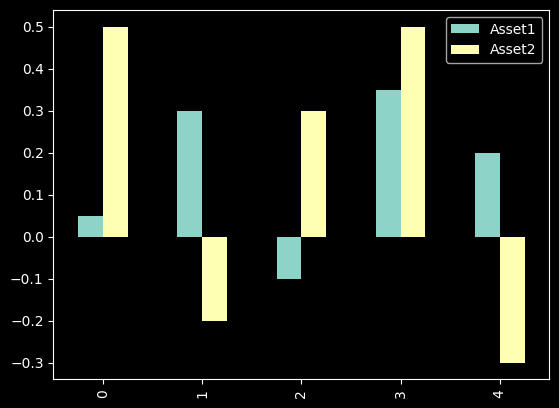

In [ ]:
return_df.plot.bar()

##### Visualizing the returns as bar charts

In [ ]:
return_df.std()
return_df.mean()

Asset1    0.16
Asset2    0.16
dtype: float64

In [ ]:
return_df + 1

,Asset1,Asset2
0,1.05,1.5
1,1.30,0.8
2,0.90,1.3
3,1.35,1.5
4,1.20,0.7


In [ ]:
init_investment = 100
cum_value = (return_df + 1).cumprod()*100
cum_value

,Asset1,Asset2
0,105.0000,150.0
1,136.5000,120.0
2,122.8500,156.0
3,165.8475,234.0
4,199.0170,163.8


<Axes: >

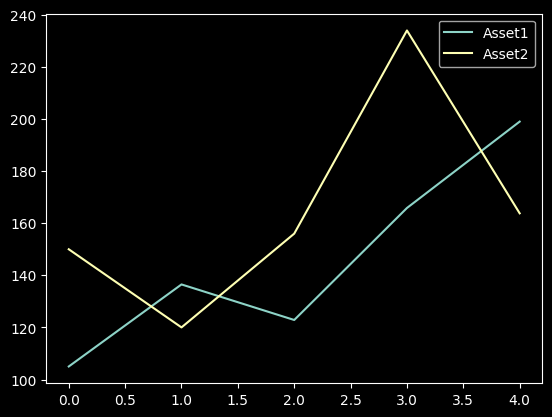

In [ ]:
cum_value.plot.line()

### Calculating Single-Period Returns from Price Data

In [ ]:
prices = [0.1, 0.2, -0.05]

In [ ]:
prices[1]/prices[0] - 1

-1.25

In [ ]:
prices[2]/prices[1] - 1

-1.25

In [ ]:
print(prices[1:])

[0.2, -0.05]


In [ ]:
print(prices[:-1])

[0.1, 0.2]


In [ ]:
print(np.array(prices[1:])/np.array(prices[:-1])-1)

[ 1.   -1.25]


In [ ]:
prices_df = pd.DataFrame({"price":prices})
prices_df
prices_df

,price
0,0.10
1,0.20
2,-0.05


In [ ]:
prices_df.iloc[1:]/prices_df.iloc[:-1]

,price
0,NaN
1,1.0
2,NaN


In [ ]:
prices_df.iloc[1:]

,price
1,0.20
2,-0.05


In [ ]:
prices_df.iloc[:-1]

,price
0,0.1
1,0.2


In [ ]:
prices_df.iloc[1:].values/prices_df.iloc[:-1] - 1


,price
0,1.00
1,-1.25


In [ ]:
prices_df.iloc[1:]/prices_df.iloc[:-1].values - 1


,price
1,1.00
2,-1.25


In [ ]:
prices_df.shift(1)


,price
0,NaN
1,0.1
2,0.2


In [ ]:
prices_df/prices_df.shift(1) - 1

,price
0,NaN
1,1.00
2,-1.25


In [ ]:
returns_df = prices_df.pct_change()
returns_df

,price
0,NaN
1,1.00
2,-1.25


### Calculating Two-Period Terminal Return

In [ ]:
returns_df + 1

,price
0,NaN
1,2.00
2,-0.25


In [ ]:
np.prod(returns_df + 1) - 1

/Users/jas3540/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



price   -1.5
dtype: float64

In [ ]:
(returns_df+1).prod() - 1

price   -1.5
dtype: float64

### Calculating Annualized Returns

For the daily return, we assume a total of 252 trading days in a year, which is a
typical assumption when working with daily prices. We follow the same recipe here:
convert normal return to 1+R return for every single period, compound/multiply these
single periods until reaching a year, and minus one to convert back to the normal
terminal return:

In [ ]:
r = 0.0001
(1+r)**252-1

0.025518911987694626

For the monthly return, since there are 12 months in a year, we would compound it
12 times:

In [ ]:
r = 0.01
(1+r)**12-1

0.12682503013196977

And lastly, there are four quarters in a year, so we compound it four times:

In [ ]:
r = 0.05
(1+r)**4-1

0.21550625000000023

### Combining Risk and Return via the Sharpe Ratio

In [ ]:
p1_ret = 0.05
p1_vol = 0.2
p2_ret = 0.1
p2_vol = 0.5
risk_free_rate = 0.03
p1_ret / p1_vol

0.14

In [ ]:
p2_ret / p2_vol

0.2

In [ ]:
(p1_ret - risk_free_rate) / p1_vol

0.10000000000000002

In [ ]:

(p2_ret - risk_free_rate) / p2_vol

0.14

### Working with Stock Price Data

##### Downloading stock data using yfinance

In [ ]:
prices_df = yf.download(["AAPL","GOOG"], start="2024-01-01")
prices_df.head()

[*********************100%%**********************]  2 of 2 completed


Price        Adj Close                   Close                    High  \
Ticker            AAPL        GOOG        AAPL        GOOG        AAPL   
Date                                                                     
2024-01-02  185.152283  139.401367  185.639999  139.559998  188.440002   
2024-01-03  183.765930  140.200455  184.250000  140.360001  185.880005   
2024-01-04  181.432098  137.883087  181.910004  138.039993  183.089996   
2024-01-05  180.703995  137.233841  181.179993  137.389999  182.759995   
2024-01-08  185.072495  140.370270  185.559998  140.529999  185.600006   

Price                          Low                    Open              \
Ticker            GOOG        AAPL        GOOG        AAPL        GOOG   
Date                                                                     
2024-01-02  140.615005  183.889999  137.740005  187.149994  139.600006   
2024-01-03  141.089996  183.429993  138.429993  184.220001  138.600006   
2024-01-04  140.634995  180.880005  138.009995  182.149994  139.850006   
2024-01-05  138.809998  180.169998  136.850006  181.990005  138.352005   
2024-01-08  140.639999  181.500000  137.880005  182.089996  138.000000   

Price         Volume            
Ticker          AAPL      GOOG  
Date                            
2024-01-02  82488700  20071900  
2024-01-03  58414500  18974300  
2024-01-04  71983600  18253300  
2024-01-05  62303300  15433200  
2024-01-08  59144500  17645300

##### Indexing by date and selecting the daily adjusted closing price

In [ ]:
# convert datetime index to date format
prices_df.index = prices_df.index.date
# keep the adjust close
prices_df = prices_df['Adj Close']
prices_df.head()

Ticker,AAPL,GOOG
2024-01-02,185.152283,139.401367
2024-01-03,183.765930,140.200455
2024-01-04,181.432098,137.883087
2024-01-05,180.703995,137.233841
2024-01-08,185.072495,140.370270


In [ ]:
returns_df = prices_df.pct_change()
returns_df.head()

Ticker,AAPL,GOOG
2024-01-02,NaN,NaN
2024-01-03,-0.007488,0.005732
2024-01-04,-0.012700,-0.016529
2024-01-05,-0.004013,-0.004709
2024-01-08,0.024175,0.022855


In [ ]:
returns_df = returns_df.dropna()
returns_df.head()

Ticker,AAPL,GOOG
2024-01-03,-0.007488,0.005732
2024-01-04,-0.012700,-0.016529
2024-01-05,-0.004013,-0.004709
2024-01-08,0.024175,0.022855
2024-01-09,-0.002263,0.014445


### Calculating the Mean, Variance, and Standard Deviation

In [ ]:
returns_df.mean()

Ticker
AAPL    0.001691
GOOG    0.002623
dtype: float64

In [ ]:
returns_df.std(axis=0)

Ticker
AAPL    0.015320
GOOG    0.017377
dtype: float64

In [ ]:
deviations_df = returns_df - returns_df.mean()

In [ ]:
deviations_df.head()

Ticker,AAPL,GOOG
2024-01-03,-0.009179,0.003109
2024-01-04,-0.014391,-0.019152
2024-01-05,-0.005704,-0.007331
2024-01-08,0.022484,0.020232
2024-01-09,-0.003954,0.011822


In [ ]:
squared_deviations_df = deviations_df**2
squared_deviations_df.head()

Ticker,AAPL,GOOG
2024-01-03,0.000084,0.000010
2024-01-04,0.000207,0.000367
2024-01-05,0.000033,0.000054
2024-01-08,0.000506,0.000409
2024-01-09,0.000016,0.000140


In [ ]:
variance = squared_deviations_df.mean()
variance

Ticker
AAPL    0.000233
GOOG    0.000300
dtype: float64

In [ ]:
volatility = np.sqrt(variance)
volatility

Ticker
AAPL    0.015260
GOOG    0.017309
dtype: float64

##### Calculating the sample variance

In [ ]:
num_rows = squared_deviations_df.shape[0]
variance2 = squared_deviations_df.sum() / (num_rows-1)
variance2

Ticker
AAPL    0.000235
GOOG    0.000302
dtype: float64

In [ ]:
volatility2 = np.sqrt(variance2)
volatility2

Ticker
AAPL    0.015320
GOOG    0.017377
dtype: float64

### Calculating the Annualized Volatility

In [ ]:
annualized_vol = returns_df.std()*np.sqrt(252)
annualized_vol

Ticker
AAPL    0.243200
GOOG    0.275844
dtype: float64

In [ ]:
annualized_vol = returns_df.std()*(252**0.5)
annualized_vol

Ticker
AAPL    0.243200
GOOG    0.275844
dtype: float64

### Calculating the Annualized Returns

In [ ]:
returns_per_day = (returns_df+1).prod()**(1/returns_df.shape[0]) - 1
returns_per_day

Ticker
AAPL    0.001576
GOOG    0.002474
dtype: float64

##### Annualizing the daily return

In [ ]:
annualized_return = (returns_per_day+1)**252-1
annualized_return

Ticker
AAPL    0.487109
GOOG    0.863906
dtype: float64

In [ ]:
annualized_return = (returns_df+1).prod()**(252/returns_df.shape[0])-1
annualized_return

Ticker
AAPL    0.487109
GOOG    0.863906
dtype: float64

### Calculating the Sharpe Ratio

In [ ]:
riskfree_rate = 0.03
excess_return = annualized_return - riskfree_rate
sharpe_ratio = excess_return/annualized_vol
sharpe_ratio

Ticker
AAPL    1.879561
GOOG    3.023107
dtype: float64

########################################################################################################################